In [1]:
import pandas as pd
import numpy as np
from os.path import join
from datetime import datetime, timezone
from twarc import Twarc2

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

import sys
sys.path.insert(0, "/home/jana/Projects/utilities/twitter_functions")
import twitter_functions as tf

In [2]:
src = "../../data/twitter/US_politician_twitter_accounts/clean"
dst = "../../data/twitter/US_politician_twitter_timelines"

In [3]:
handles = pd.read_csv(join(src, "congress-member-unique-twitter-handles_114-117.csv"))

# Get user IDs

In [13]:
name = "michaela"
credentials = tf.get_twitter_API_credentials(namelist=[name])
client = Twarc2(bearer_token=credentials[name])

In [51]:
users = pd.DataFrame()
batch_size = 100
N_batches = int(len(handles) / batch_size)

for batch in range(N_batches + 1):
    print(f"processing batch {batch}")
    batch_handles = handles["handle"][batch * batch_size:(batch + 1) * batch_size]
    for user_bunch in client.user_lookup(batch_handles.values, usernames=True):
        for user in user_bunch["data"]:
            
            try:
                location = user["location"]
            except KeyError:
                location = np.nan
            
            row = {"id":user["id"],
                   "handle":user["username"],
                   "name":user["name"],
                   "created_at":user["created_at"],
                   "verified":user["verified"],
                   "protected":user["protected"],
                   "location":location,
                   "description":user["description"],
                   "downloaded":str(datetime.today()).split(".")[0],
                   "followers_count":user["public_metrics"]["followers_count"],
                   "following_count":user["public_metrics"]["following_count"],
                   "tweet_count":user["public_metrics"]["tweet_count"],
                   "listed_count":user["public_metrics"]["listed_count"]}
            users = users.append(row, ignore_index=True)
        
for col in ["followers_count", "following_count", "id", "listed_count", 
            "protected", "tweet_count", "verified"]:
    users[col] = users[col].astype(int)
users.to_csv(join(src, "congress-member-unique-twitter-accounts_114-117.csv"), index=False)

processing batch 0
processing batch 1
processing batch 2
processing batch 3
processing batch 4
processing batch 5
processing batch 6
processing batch 7
processing batch 8
processing batch 9
processing batch 10
processing batch 11


In [52]:
diff = list(set(handles["handle"]).difference(set(users["handle"])))
print(f"{len(diff)} user profiles could not be retrieved")

102 user profiles could not be retrieved


# Get user timelines

In [6]:
users = pd.read_csv(join(src, "congress-member-unique-twitter-accounts_114-117.csv"))
remaining_users = list(users["id"].values)

In [11]:
N_tasks = 5
namelist = ['michaela', 'simon', 'johanness', 'flo', 'caspar']
print(f"using keys from {namelist}")
credentials = tf.get_twitter_API_credentials(namelist=namelist,
                        keydst="/home/jana/Projects/utilities/twitter_API_keys")
# apparently the API does not return timelines before 2010-11-06 (tested)
start = datetime(2021, 12, 14, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2022, 3, 15, 0, 0, 0, 0, tzinfo=timezone.utc)
task_info = tf.create_crawlinfo(N_tasks, remaining_users, 
                                start, end, dst, credentials)

using keys from ['michaela', 'simon', 'johanness', 'flo', 'caspar']


In [13]:
number_of_cores = len(namelist)
pool = Pool(number_of_cores)

for task in tqdm(pool.imap_unordered(func=tf.get_user_timelines,
                                     iterable=task_info),
                                     total=len(task_info)):
        pass

  0%|                                                               | 0/5 [00:00<?, ?it/s]caught 503 from Twitter API, sleeping 1
caught 503 from Twitter API, sleeping 1
100%|██████████████████████████████████████████████████████| 5/5 [10:19<00:00, 123.87s/it]


# Collect user timelines

In [22]:
import json

def stitch_json_timeline(ID, src):
    json_timeline = []
    with open(join(src,
        f'{ID}_usertimeline_2010-11-06_to_2021-12-14.json'), 'r') as f:
        for line in f:
            try:
                json_timeline.append(json.loads(line))
            except JSONDecodeError:
                print(f"JSONDecodeError for ID {ID}")
    with open(join(src,
        f'{ID}_usertimeline_2021-12-14_to_2022-03-15.json'), 'r') as f:
        for line in f:
            try:
                json_timeline.append(json.loads(line))
            except JSONDecodeError:
                print(f"JSONDecodeError for ID {ID}")
            
    return json_timeline

In [16]:
from importlib import reload
reload(tf)

<module 'twitter_functions' from '/home/jana/Projects/utilities/twitter_functions/twitter_functions.py'>

In [20]:
def extract_information(ID):
    tmp = pd.DataFrame()
    try:
        #json_timeline = tf.load_json_timeline(ID, src2)
        json_timeline = stitch_json_timeline(ID, src2)
    except FileNotFoundError:
        return tmp
    
    for tl_obj in json_timeline:
        tmp = pd.concat([tmp, tf.unravel_data(tl_obj)])
    return tmp

In [23]:
start = datetime(2010, 11, 6, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2022, 3, 15, 0, 0, 0, 0, tzinfo=timezone.utc)
src1 = "../../data/twitter/US_politician_twitter_accounts/clean"
src2 = "../../data/twitter/US_politician_twitter_timelines"
dst = "../../data/twitter/"
users = pd.read_csv(join(src1, "congress-member-unique-twitter-accounts_114-117.csv"))

number_of_cores = 10
pool = Pool(number_of_cores)
timelines = pd.DataFrame()

for tmp in tqdm(pool.imap_unordered(func=extract_information, 
                    iterable=users["id"].values), total=len(users)):
        timelines = pd.concat([timelines, tmp])

fname = "combined_US_politician_twitter_timelines_{}_to_{}_raw.csv.gzip"\
    .format(str(start).split(" ")[0], str(end).split(" ")[0])
timelines.to_csv(join(dst, fname), compression="gzip", index=False)

100%|█████████████████████████████████████████████████| 1065/1065 [30:41<00:00,  1.73s/it]


# Clean user timelines

In [24]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-15_raw.csv.gzip"
src = "../../data/twitter/"
timelines = pd.read_csv(join(src, fname), compression="gzip")

/home/jana/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6,7,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
N = len(timelines)
timelines = timelines[timelines["lang"] == "en"]
timelines = timelines.dropna(subset=["id"])
print(f"dropped {N - len(timelines)} non-english Tweets")

dropped 58326 non-english Tweets


In [26]:
timelines["reference_type"] = timelines["reference_type"].fillna("[]")
timelines["reference_type"] = timelines["reference_type"].apply(lambda x: eval(x))

In [27]:
timelines["retweeted"] = timelines["reference_type"].apply(tf.check_retweet)
timelines["quoted"] = timelines["reference_type"].apply(tf.check_quoted)
timelines["reply"] = timelines["reference_type"].apply(tf.check_reply)
timelines = timelines.drop(columns=["reference_type"])

In [28]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_clean.csv.gzip"
dst = "../../data/twitter/"
timelines.to_csv(join(dst, fname), index=False, compression="gzip")

# Corpus statistics

In [4]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_clean.csv.gzip"
dst = "../../data/twitter/"
timelines = pd.read_csv(join(dst, fname), compression="gzip")

/home/jana/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
print(f"number of tweets in the corpus: {len(timelines)}")
print("number of original in the corpus: {}"\
      .format(len(timelines[(timelines["retweeted"] == False) &\
                            (timelines["quoted"] == False) &\
                            (timelines["reply"] == False)])))
print("number of quoted tweets in the corpus: {}"\
      .format(len(timelines[timelines["quoted"] == True])))
print("number of replies in the corpus: {}"\
      .format(len(timelines[timelines["reply"] == True])))
print("number of retweets in the corpus: {}"\
      .format(len(timelines[timelines["retweeted"] == True])))

number of tweets in the corpus: 2717708
number of original in the corpus: 1636528
number of quoted tweets in the corpus: 270603
number of replies in the corpus: 252576
number of retweets in the corpus: 560648


In [6]:
1636528 + 270603 + 252576 + 560648

2720355

In [7]:
len(timelines["author_id"].unique())

1035

In [8]:
timelines["year"] = pd.to_datetime(timelines["created_at"]).dt.year

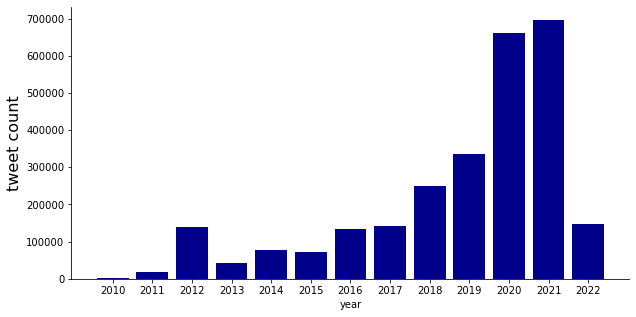

In [10]:
import matplotlib.pyplot as plt
import numpy as np
counts, years = np.histogram(timelines["year"], bins=range(2010, 2022))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(timelines["year"].value_counts(ascending=True).index,
       timelines["year"].value_counts(ascending=True).values,
       color="DarkBlue")
ax.set_xticks(range(2010, 2023))
ax.set_ylabel("tweet count", fontsize=16)
ax.set_xlabel("year", fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("../../plots/corpus_tweets_year_count.pdf")
plt.savefig("../../plots/corpus_tweets_year_count.svg")